<a href="https://colab.research.google.com/github/luisfmnunes/mxnet-r100-arface/blob/main/mxnet_r100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load pré trained ResNet100 (MxNet) and extract embeddings to compare

## Downgrading CUDA to 10.1

In [ ]:
!cat /etc/*release*

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [ ]:
!ls -l /usr/local

total 68
drwxr-xr-x 1 root root 4096 Apr  1 14:00 bin
drwxr-xr-x 3 root root 4096 Apr  1 13:59 cuda-10.2
drwxr-xr-x 1 root root 4096 Apr  1 14:00 cuda-11.0
drwxr-xr-x 1 root root 4096 Mar 29 13:29 etc
drwxr-xr-x 2 root root 4096 Sep 21  2020 games
drwxr-xr-x 2 root root 4096 Mar 29 13:41 _gcs_config_ops.so
drwxr-xr-x 1 root root 4096 Mar 29 13:49 include
drwxr-xr-x 1 root root 4096 Mar 29 13:49 lib
-rw-r--r-- 1 root root 1636 Mar 29 13:43 LICENSE.txt
drwxr-xr-x 3 root root 4096 Mar 29 13:40 licensing
lrwxrwxrwx 1 root root    9 Sep 21  2020 man -> share/man
drwxr-xr-x 2 root root 4096 Sep 21  2020 sbin
-rw-r--r-- 1 root root 7291 Mar 29 13:43 setup.cfg
drwxr-xr-x 1 root root 4096 Mar 29 13:40 share
drwxr-xr-x 2 root root 4096 Sep 21  2020 src
drwxr-xr-x 2 root root 4096 Mar 29 13:50 xgboost


In [ ]:
#Download CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#install CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0

--2021-04-05 14:27:10--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940 (2.9K) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’

cuda-repo-ubuntu180 100%[===================>]   2.87K  --.-KB/s    in 0s      

2021-04-05 14:27:10 (150 MB/s) - ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’ saved [2940/2940]

Selecting previously unselected package cuda-repo-ubuntu1804.
(Reading database ... 124084 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1804_10.0.130-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1804 (10.0.130-1) ...
Setting up cuda-repo-ubuntu1804 (10.0.130-1) ...

Configuration file '/etc/apt/sources.li

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
!nvidia-smi

Fri Mar 26 13:01:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installing MXNet Python Package

In [ ]:
!pip install mxnet-cu100

     |████████████████████████████████| 352.6MB 52kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Mount GoogleDrive Partition
  Mounts GoogleDrive using Google Colab Drive API and retrieves the model from the drive.

In [ ]:
import os
from google.colab import drive

if not os.path.exists('/gdrive'):
  drive.mount('/gdrive')

!cp -v /gdrive/MyDrive/model-r100-mxnet.zip .
!cp -v /gdrive/MyDrive/images.zip .
!cp -v /gdrive/MyDrive/glint360k_r100FC.zip .
!cp -v /gdrive/MyDrive/retinaface-R50.zip .

Mounted at /gdrive
'/gdrive/MyDrive/model-r100-mxnet.zip' -> './model-r100-mxnet.zip'
'/gdrive/MyDrive/images.zip' -> './images.zip'
'/gdrive/MyDrive/glint360k_r100FC.zip' -> './glint360k_r100FC.zip'
'/gdrive/MyDrive/retinaface-R50.zip' -> './retinaface-R50.zip'


In [ ]:
import zipfile
with zipfile.ZipFile('model-r100-mxnet.zip', 'r') as zip_ref:
  zip_ref.extractall('model')
with zipfile.ZipFile('images.zip','r') as zip_images:
  zip_images.extractall('images')
with zipfile.ZipFile('retinaface-R50.zip', 'r') as zip_retina:
  zip_retina.extractall('fd')
with zipfile.ZipFile('glint360k_r100FC.zip', 'r') as zip_fc:
  zip_fc.extractall('fr') 

In [ ]:
!rm -f *.zip

## Loading PreTrained Model (MS1M)


In [ ]:
import json
import cv2
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mxnet import gluon, nd, autograd
from mxnet.gluon.model_zoo import vision
from mxnet import image
import numpy as np
from collections import namedtuple
%matplotlib inline

In [ ]:
mx.__version__

'1.8.0'

In [ ]:
print('Avilable GPU: {}'.format(mx.context.num_gpus()))

Avilable GPU: 1


In [ ]:
mx.runtime.feature_list()

[✔ CUDA,
 ✔ CUDNN,
 ✔ NCCL,
 ✔ CUDA_RTC,
 ✖ TENSORRT,
 ✔ CPU_SSE,
 ✔ CPU_SSE2,
 ✔ CPU_SSE3,
 ✖ CPU_SSE4_1,
 ✖ CPU_SSE4_2,
 ✖ CPU_SSE4A,
 ✖ CPU_AVX,
 ✖ CPU_AVX2,
 ✔ OPENMP,
 ✖ SSE,
 ✖ F16C,
 ✖ JEMALLOC,
 ✔ BLAS_OPEN,
 ✖ BLAS_ATLAS,
 ✖ BLAS_MKL,
 ✖ BLAS_APPLE,
 ✔ LAPACK,
 ✔ MKLDNN,
 ✔ OPENCV,
 ✖ CAFFE,
 ✖ PROFILER,
 ✔ DIST_KVSTORE,
 ✖ CXX14,
 ✖ INT64_TENSOR_SIZE,
 ✔ SIGNAL_HANDLER,
 ✖ DEBUG,
 ✖ TVM_OP]

In [ ]:
# Sets context to CPU usage
#ctx = mx.cpu()
ctx = mx.gpu(0) if mx.context.num_gpus() else mx.cpu()

### Using GLUON SymbolBlock

In [ ]:
r100_net = gluon.nn.SymbolBlock.imports('model/model-r100-ii/model-symbol.json', ['data'], 'model/model-r100-ii/model-0000.params', ctx=ctx)
type(r100_net)


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1591: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


mxnet.gluon.block.SymbolBlock

In [ ]:
def load_images(path):
  images_path = []
  labels = []
  path_exp = os.path.expanduser(path)
  classes = [path for path in os.listdir(path_exp) \
             if os.path.isdir(os.path.join(path_exp,path))]
  classes.sort()
  nrof_classes = len(classes)
  for i in range(nrof_classes):
    class_name = classes[i]
    labels.append(class_name)
    class_dir = os.path.join(path_exp,class_name)
    class_images = [os.path.join(class_dir,img) for img in os.listdir(class_dir)]
    images_path.append(class_images)
  
  return images_path, labels
 
def get_image(path):
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (112,112))
  img = np.swapaxes(img, 0, 2)
  img = np.swapaxes(img, 1, 2)
  img = img[np.newaxis, :]
  return img.astype(np.float32)

def channel_last(img):
  img = np.swapaxes(img[0], 1, 2)
  img = np.swapaxes(img, 0, 2)
  return img.astype(np.uint8)

In [ ]:
print(r100_net.collect_params())

(
  Parameter conv0_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter bn0_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter bn0_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter relu0_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn1_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn1_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_conv1_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn2_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn2_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_relu1_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_conv2_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn3_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter stage1_unit1_bn3_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter st

In [ ]:
imgs_path, labels = load_images('images')
print(imgs_path)
print(labels)

[['images/id_103181/103181_6277842.jpg', 'images/id_103181/103181_6277844.jpg', 'images/id_103181/103181_6277840.jpg', 'images/id_103181/103181_6277841.jpg', 'images/id_103181/103181_6277843.jpg'], ['images/id_104203/104203_6332887.jpg', 'images/id_104203/104203_6332843.jpg', 'images/id_104203/104203_6332841.jpg', 'images/id_104203/104203_6332902.jpg', 'images/id_104203/104203_6332915.jpg', 'images/id_104203/104203_6332832.jpg', 'images/id_104203/104203_6332879.jpg', 'images/id_104203/104203_6332874.jpg', 'images/id_104203/104203_6332748.jpg', 'images/id_104203/104203_6332808.jpg', 'images/id_104203/104203_6332877.jpg', 'images/id_104203/104203_6332796.jpg', 'images/id_104203/104203_6332771.jpg', 'images/id_104203/104203_6332824.jpg', 'images/id_104203/104203_6332764.jpg', 'images/id_104203/104203_6332746.jpg', 'images/id_104203/104203_6332865.jpg', 'images/id_104203/104203_6332740.jpg', 'images/id_104203/104203_6332834.jpg', 'images/id_104203/104203_6332840.jpg', 'images/id_104203/104

(5, 3, 112, 112)
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (5, 3, 112, 112)               0
       SymbolBlock-1                                    (5, 512)        65225792
Parameters in forward computation graph, duplicate included
   Total params: 65225792
   Trainable params: 65156160
   Non-trainable params: 69632
Shared params in forward computation graph: 0
Unique parameters in model: 65225792
--------------------------------------------------------------------------------


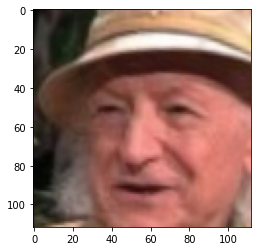

In [ ]:
imgs = [img for img in [mpimg.imread(I) for I in imgs_path[0]]]
imgs[4] = mpimg.imread(imgs_path[1][0])
plt.imshow(imgs[3])
np_array = np.array(imgs)
nd_array = nd.array(np_array)
nd_array = nd_array.transpose((0,3,1,2))
print(nd_array.shape)
r100_net.summary(nd_array)

In [ ]:
# print(embeddings.shape)
# embeddings = embeddings.softmax()
# print(embeddings)
# emb_trans = embeddings.transpose((1,0))
# print(emb_trans.shape)
# print(nd.sum(embeddings,axis=1))
# conf_matrix = 2 - 2*nd.dot(embeddings,emb_trans).asnumpy()**2
# print(conf_matrix)

### Using Symbol Model

In [ ]:
symbol, arg_params, aux_params = mx.model.load_checkpoint('model/model-r100-ii/model',0000)

In [ ]:
print(symbol)
print(type(arg_params))
print(type(aux_params))

<Symbol fc1>
<class 'dict'>
<class 'dict'>


In [ ]:
mx.visualization.print_summary(symbol)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
id(_copy)                                                                   0           data                            
________________________________________________________________________________________________________________________
_minusscalar0(_minus_scalar)                                                0           id                              
________________________________________________________________________________________________________________________
_mulscalar0(_mul_scalar)        

In [ ]:
mx.visualization.plot_network(symbol,shape={'data':(1,3,112,112)})

In [ ]:
print(symbol.list_outputs())
print(symbol.list_inputs())
print(symbol.list_arguments())

['fc1_output']
['data', 'conv0_weight', 'bn0_gamma', 'bn0_beta', 'bn0_moving_mean', 'bn0_moving_var', 'relu0_gamma', 'stage1_unit1_bn1_gamma', 'stage1_unit1_bn1_beta', 'stage1_unit1_bn1_moving_mean', 'stage1_unit1_bn1_moving_var', 'stage1_unit1_conv1_weight', 'stage1_unit1_bn2_gamma', 'stage1_unit1_bn2_beta', 'stage1_unit1_bn2_moving_mean', 'stage1_unit1_bn2_moving_var', 'stage1_unit1_relu1_gamma', 'stage1_unit1_conv2_weight', 'stage1_unit1_bn3_gamma', 'stage1_unit1_bn3_beta', 'stage1_unit1_bn3_moving_mean', 'stage1_unit1_bn3_moving_var', 'stage1_unit1_conv1sc_weight', 'stage1_unit1_sc_gamma', 'stage1_unit1_sc_beta', 'stage1_unit1_sc_moving_mean', 'stage1_unit1_sc_moving_var', 'stage1_unit2_bn1_gamma', 'stage1_unit2_bn1_beta', 'stage1_unit2_bn1_moving_mean', 'stage1_unit2_bn1_moving_var', 'stage1_unit2_conv1_weight', 'stage1_unit2_bn2_gamma', 'stage1_unit2_bn2_beta', 'stage1_unit2_bn2_moving_mean', 'stage1_unit2_bn2_moving_var', 'stage1_unit2_relu1_gamma', 'stage1_unit2_conv2_weight', 

In [ ]:
# print(arg_params['data'])
# print(arg_params['conv0_weight'])

In [ ]:
# symbol.bind(ctx,arg_params)
mod = mx.mod.Module(symbol=symbol, context=ctx, label_names=None)
mod.bind(for_training=False ,data_shapes=[('data',(1,3,112,112))], label_shapes=mod._label_shapes)
mod.set_params(arg_params,aux_params, allow_missing=True)

In [ ]:
Batch = namedtuple('Batch',['data'])

(1, 3, 112, 112)
float32
[-0.57964903 -0.14922711  0.00884503  0.4811281  -0.7671937  -0.3743021
  0.01129413 -0.32857984 -0.4394851   0.33637598]


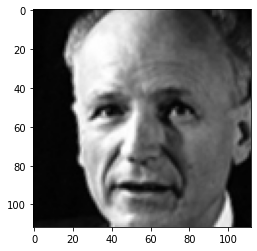

In [ ]:
# Run the model in the first image of the first class
image = get_image(imgs_path[0][2])
plt.imshow(channel_last(image))
print(np.shape(image))
print(image.dtype)
mod.forward(Batch([mx.nd.array(image)]))
emb_nd = mod.get_outputs()[0]
emb = mod.get_outputs()[0].asnumpy()
print(emb[0][:10])

In [ ]:
# Normalize the embeddings result
emb_nd_sq = emb_nd.softmax().sqrt()
print(emb_nd_sq[0])
print(emb_nd[0])
print('Module: {}'.format(nd.dot(emb_nd_sq,emb_nd_sq.transpose((1,0)))[0].asscalar()))


[0.10887675 0.02754883 0.01785572 0.10501852 0.0570041  0.02481172
 0.02978694 0.06877062 0.02274551 0.01821101 0.01984922 0.03560689
 0.05570059 0.02781017 0.01999448 0.02692448 0.0390946  0.03752415
 0.05065928 0.03890647 0.01978083 0.03848336 0.02170129 0.04333629
 0.03551547 0.05475525 0.02752228 0.04396982 0.01820488 0.0417473
 0.0228846  0.02432985 0.05218698 0.04038076 0.03426748 0.0409155
 0.02744054 0.0567903  0.03227549 0.04739317 0.03936822 0.04370787
 0.02213035 0.01622061 0.03555219 0.04283057 0.03495935 0.04890599
 0.05793204 0.03761162 0.03938808 0.04430932 0.02355831 0.03014246
 0.02773824 0.03192409 0.01724184 0.01509186 0.05382258 0.02666262
 0.0405583  0.02883229 0.0348079  0.03657889 0.0265688  0.0191533
 0.03348645 0.01943053 0.0118669  0.04720502 0.08222237 0.0433682
 0.05414758 0.03396274 0.01745061 0.02215603 0.03742801 0.02464018
 0.04726957 0.04008604 0.02265047 0.01622256 0.03642985 0.01758661
 0.0389761  0.01843865 0.03143562 0.02776476 0.02267489 0.0302834

(1, 3, 112, 112)
[ 0.5876943  -0.7566217  -0.18349646  1.5043969   1.7315937  -0.13695538
 -0.7183092   0.21586111  0.37210342 -1.324328  ]
(1, 512)


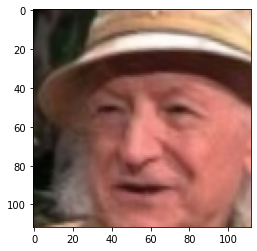

In [ ]:
# Run the model in the second image of the first class and Normalize the embedding result
image2 = get_image(imgs_path[0][3])
plt.imshow(channel_last(image2))
print(np.shape(image2))
mod.forward(Batch([mx.nd.array(image2)]))
emb_nd2 = mod.get_outputs()[0]
emb2 = mod.get_outputs()[0].asnumpy()
print(emb2[0][:10])
emb_nd_sq2 = emb_nd2.softmax().sqrt()
print(emb_nd2.shape)

In [ ]:
# Difference between the embeddings

diff_cos = nd.dot(emb_nd,emb_nd2.transpose((1,0)))
print('Original Embedding Dot Diff = {}'.format(diff_cos[0].asscalar()))

diff_norm_cos = nd.dot(emb_nd_sq,emb_nd_sq2.transpose((1,0)))
print('Normalized Embedding Dot Diff = {}'.format(diff_norm_cos[0].asscalar()))

Original Embedding Dot Diff = 450.5955810546875
Normalized Embedding Dot Diff = 0.8840335011482239


In [ ]:
print(emb_nd_sq)


[[0.10887675 0.02754883 0.01785572 0.10501852 0.0570041  0.02481172
  0.02978694 0.06877062 0.02274551 0.01821101 0.01984922 0.03560689
  0.05570059 0.02781017 0.01999448 0.02692448 0.0390946  0.03752415
  0.05065928 0.03890647 0.01978083 0.03848336 0.02170129 0.04333629
  0.03551547 0.05475525 0.02752228 0.04396982 0.01820488 0.0417473
  0.0228846  0.02432985 0.05218698 0.04038076 0.03426748 0.0409155
  0.02744054 0.0567903  0.03227549 0.04739317 0.03936822 0.04370787
  0.02213035 0.01622061 0.03555219 0.04283057 0.03495935 0.04890599
  0.05793204 0.03761162 0.03938808 0.04430932 0.02355831 0.03014246
  0.02773824 0.03192409 0.01724184 0.01509186 0.05382258 0.02666262
  0.0405583  0.02883229 0.0348079  0.03657889 0.0265688  0.0191533
  0.03348645 0.01943053 0.0118669  0.04720502 0.08222237 0.0433682
  0.05414758 0.03396274 0.01745061 0.02215603 0.03742801 0.02464018
  0.04726957 0.04008604 0.02265047 0.01622256 0.03642985 0.01758661
  0.0389761  0.01843865 0.03143562 0.02776476 0.022

In [ ]:
print(emb[0][:10])
print(emb2[0][:10])
print(np.linalg.norm(emb - emb2,axis=1))

[ 2.240545   -0.50796825 -1.3752401   2.1683853   0.94635814 -0.71725595
 -0.35174796  1.3216652  -0.8911522  -1.3358356 ]
[ 0.5876943  -0.7566217  -0.18349646  1.5043969   1.7315937  -0.13695538
 -0.7183092   0.21586111  0.37210342 -1.324328  ]
[21.176403]


In [ ]:
diff_euclidean = np.linalg.norm(emb - emb2, axis = 1)
print ('Original Embedding Euclidean Dist = {}'.format(diff_euclidean[0]))

diff_norm_euclidean = np.linalg.norm(emb_nd_sq.asnumpy() - emb_nd_sq2.asnumpy(), axis = 1)
print ('Normalized Embedding Euclidean Dist = {}'.format(diff_norm_euclidean[0]))

Original Embedding Euclidean Dist = 21.176403045654297
Normalized Embedding Euclidean Dist = 0.4815942645072937


## Evaluate Embeddings
Extract templates from images and compare their scores

In [ ]:
class Template:
  def __init__(self,data,label,filename):
    self.data = data
    self.label = label
    self.filename = filename

In [ ]:
import math
def euclidean_dist(tpt1, tpt2):
  diff = np.subtract(tpt1.data,tpt2.data)
  dist = np.sum(np.square(diff),axis=1)
  return dist

def cosine_dist(tpt1, tpt2):
  dot = np.sum(np.multiply(tpt1.data,tpt2.data),axis=1)
  norm = np.linalg.norm(tpt1.data) * np.linalg.norm(tpt2.data)

  similarity = dot/norm
  similarity = np.clip(similarity,-1,1)
  dist = np.arccos(similarity)/math.pi
  return dist

In [ ]:
def extract_templates(model,labels, img_paths):
  output = []
  for i in range(len(labels)):
    print('Extracting Templates with label {} ({} out of {})'.format(labels[i],i+1,len(labels)))
    for img in img_paths[i]:
      if not os.path.exists(img):
        continue
      image = get_image(img)
      model.forward(Batch([mx.nd.array(image)]))
      emb = model.get_outputs()[0].asnumpy()

      temp = Template(emb,labels[i],os.path.basename(img))
      output.append(temp)

  return output

### Extract Templates

In [ ]:
tpts = []
for i in range(len(labels)):
  print('Extracting Templates with label {} ({} out of {})'.format(labels[i],i+1,len(labels)))
  for img in imgs_path[i]:
    image = get_image(img)
    mod.forward(Batch([mx.nd.array(image)]))
    emb = mod.get_outputs()[0].asnumpy()

    tpt = Template(emb,labels[i],os.path.basename(img))
    # print('Extracting Template from {} with label {}'.format(img,labels[i]))
    tpts.append(tpt)

Extracting Templates with label id_103181 (1 out of 250)
Extracting Templates with label id_104203 (2 out of 250)
Extracting Templates with label id_107612 (3 out of 250)
Extracting Templates with label id_111408 (4 out of 250)
Extracting Templates with label id_113725 (5 out of 250)
Extracting Templates with label id_114193 (6 out of 250)
Extracting Templates with label id_11440 (7 out of 250)
Extracting Templates with label id_114431 (8 out of 250)
Extracting Templates with label id_115142 (9 out of 250)
Extracting Templates with label id_115823 (10 out of 250)
Extracting Templates with label id_116113 (11 out of 250)
Extracting Templates with label id_116187 (12 out of 250)
Extracting Templates with label id_117767 (13 out of 250)
Extracting Templates with label id_119135 (14 out of 250)
Extracting Templates with label id_119212 (15 out of 250)
Extracting Templates with label id_12223 (16 out of 250)
Extracting Templates with label id_122622 (17 out of 250)
Extracting Templates with

In [ ]:
def write_templates(tpts, dir='templates'):
  os.makedirs(dir,exist_ok=True)

  for tpt in tpts:
    pre, ext = os.path.splitext(tpt.filename)
    outfile = ''.join([pre,'.tpt'])
    outpath = os.path.join(dir,outfile)

    str_data = ["%.8f" % dim for dim in tpt.data[0]]
    outdata = '\n'.join(str_data)

    with open(outpath, 'w') as f:
      f.write(outdata)

    print('Writting Template of {} to {}'.format(tpt.filename, outpath))

In [ ]:
#Writting templates to file
write_templates(tpts)

In [ ]:
#Copying template files to Google Drive
!cp -v templates/* /gdrive/MyDrive/templates/openvino_rnet100

### Load Templates From File (if already extracted)

In [ ]:
!cp -r /gdrive/MyDrive/templates/openvino_rnet100 .
!mv openvino_rnet100 templates

Streaming output truncated to the last 5000 lines.
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904983.tpt' -> './openvino_rnet100/264863_13904983.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904984.tpt' -> './openvino_rnet100/264863_13904984.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904985.tpt' -> './openvino_rnet100/264863_13904985.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904986.tpt' -> './openvino_rnet100/264863_13904986.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904987.tpt' -> './openvino_rnet100/264863_13904987.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904988.tpt' -> './openvino_rnet100/264863_13904988.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904989.tpt' -> './openvino_rnet100/264863_13904989.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904990.tpt' -> './openvino_rnet100/264863_13904990.tpt'
'/gdrive/MyDrive/templates/openvino_rnet100/264863_13904991.tpt' -> './openvi

In [ ]:
tpts = []

tpt_files = [os.path.join('templates',path) for path in os.listdir('templates')]
tpt_files.sort()
for ft in tpt_files:
  lb = os.path.splitext(os.path.basename(ft))[0]
  fname = lb+'.jpg'
  lb = lb.split('_')[0]

  with open(ft, 'r') as f:
    emb_data = f.read()
    emb_data = [float(D) for D in emb_data.split(sep='\n')]
    emb_data = np.array(emb_data)
    emb_data = emb_data[np.newaxis, :]
    tpts.append(Template(emb_data,lb,fname))


### Generate Pairs and Compare with Euclidean and Cosine Distance

In [ ]:
import random
import itertools 

random.seed(42)

def get_all_genpairs(tpts):
  gpairs = []
  for i, j in itertools.combinations(enumerate(tpts),2):
    if i[1].label == j[1].label:
      # print('Sample1:{} \t Sample2:{}'.format(i[1].label,j[1].label))
      gpairs.append([i[0],j[0]])
  return gpairs

def get_sub_genpairs(tpts, ratio=0.25):
  # gpairs = []
  # aux = random.sample(tpts,math.ceil(len(tpts)*ratio))
  # for i,j in itertools.combinations(enumerate(aux),2):
  #   if i[1].label == j[1].label:
  #     gpairs.append([i[0], j[0]])
  aux = get_all_genpairs(tpts)
  gpairs = random.sample(aux,math.ceil(len(aux)*ratio))
  return gpairs

In [ ]:
def generate_pairs(temp_list):
  gen = []
  gen_cos = []
  imp = []
  imp_cos = []
  gen_pair = []
  imp_pair = []

  #Build a random subset for testing
  # for i in range(100):
  #   random_tpt = random.sample(tpts, 10) #change latter to get template class info instead of lists (after cell above finishes)
  #   for a, b in itertools.combinations(random_tpt, 2):
  #     if(a.label==b.label): #equal labels
  #       gen.append(euclidean_dist(a,b))
  #       gen_cos.append(cosine_dist(a,b))
  #       gen_pair.append([a.filename,b.filename])
  #     if(not a.label==b.label): #different labels
  #       imp.append(euclidean_dist(a,b))
  #       imp_cos.append(cosine_dist(a,b))
  #       imp_pair.append([a.filename,b.filename])

  #Build all possible genuine pairs
  for i, j in get_sub_genpairs(temp_list):
    gen.append(euclidean_dist(temp_list[i],temp_list[j]))
    gen_cos.append(cosine_dist(temp_list[i],temp_list[j]))
    gen_pair.append([temp_list[i].filename,temp_list[j].filename])

  #Build impostors
  for i in range(len(gen)):
    random_tpt = random.sample(temp_list, 3)
    for a, b in itertools.combinations(random_tpt,2):
      if not a.label==b.label:
        imp.append(euclidean_dist(a,b))
        imp_cos.append(cosine_dist(a,b))
        imp_pair.append([a.filename,b.filename])

  return gen, gen_cos, gen_pair, imp, imp_cos, imp_pair

In [ ]:
def plot_histogram(hist, bin_edges):
  plt.figure()
  plt.bar(bin_edges[:-1], hist, width= (bin_edges[1]-bin_edges[0])*0.9, color='#0504aa', alpha=0.7)
  plt.xlim(min(bin_edges),max(bin_edges))
  plt.ylim(min(hist),max(hist))
  plt.grid(axis='y', alpha = 0.5)
  plt.xlabel('Score')
  plt.ylabel('Occurances')
  plt.show()

def plot_gen_imp(hists, bin_edges):
  G, I = hists
  GB, IB = bin_edges
  w = min((GB[1]-GB[0])*0.7,(IB[1]-IB[0])*0.7)
  plt.bar(GB[:-1],G,width=w ,color='#0e0eF5', label='genuines',alpha=0.7)
  plt.bar(IB[:-1],I,width=w ,color='#F50e0e', label='impostors',alpha=0.7)
  plt.legend(loc='best')
  plt.show()

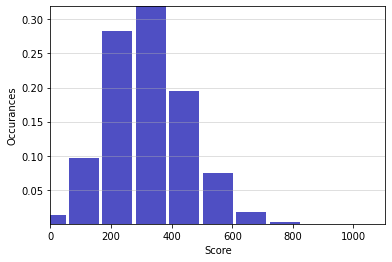

In [ ]:
gen_hist, gen_bin_edges = np.histogram(gen)
gen_hist = (gen_hist/np.sum(gen_hist))
plot_histogram(gen_hist, gen_bin_edges)

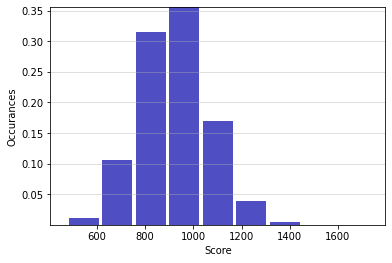

In [ ]:
imp_hist, imp_bin_edges = np.histogram(imp)
imp_hist = imp_hist/np.sum(imp_hist)
plot_histogram(imp_hist, imp_bin_edges)

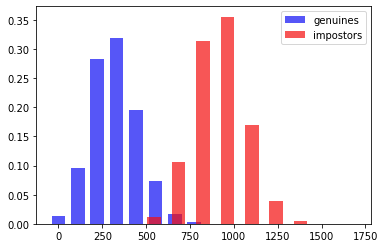

In [ ]:
plot_gen_imp([gen_hist,imp_hist],[gen_bin_edges,imp_bin_edges])

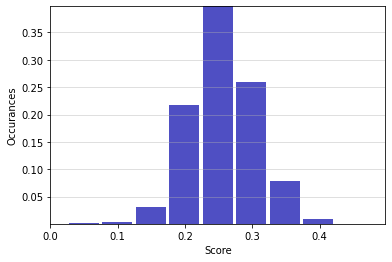

In [ ]:
gc, gcb = np.histogram(gen_cos)
gc = gc/np.sum(gc)
plot_histogram(gc,gcb)

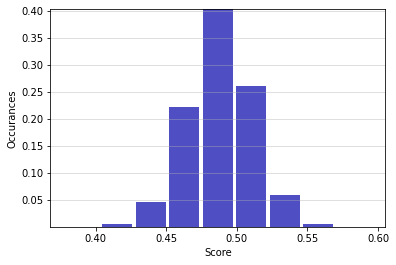

In [ ]:
ic, icb = np.histogram(imp_cos)
ic = ic/np.sum(ic)
plot_histogram(ic,icb)

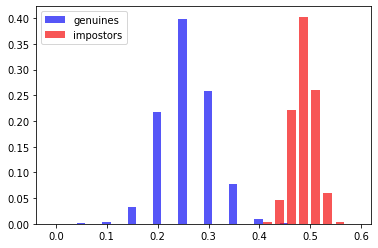

In [ ]:
plot_gen_imp([gc,ic],[gcb,icb])

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 14.1MB/s 


In [ ]:
np_gp = np.array(gen_pair)
np_gp = np_gp.reshape((2,np.shape(np_gp)[0]))

In [ ]:
import pandas as pd

def write_to_excel(gen_scores, gen_pairs, imp_scores, imp_pairs, filename='export_data.xlsx'):

  #Prepare data to insert on dataframe
  gen_eu_scores, gen_cos_scores = gen_scores
  gen_eu_scores = [eu[0] for eu in gen_eu_scores]
  gen_cos_scores = [cos[0] for cos in gen_cos_scores]
  np_gpairs = np.transpose(gen_pairs,(1,0))

  imp_eu_scores, imp_cos_scores = imp_scores
  imp_eu_scores = [eu[0] for eu in imp_eu_scores]
  imp_cos_scores = [cos[0] for cos in imp_cos_scores]
  np_ipairs = np.transpose(imp_pairs,(1,0))

  dfg_eu = pd.DataFrame(zip(np_gpairs[0], np_gpairs[1], gen_eu_scores), columns=['sample_1','sample_2','score'])
  dfg_cos = pd.DataFrame(zip(np_gpairs[0], np_gpairs[1], gen_cos_scores), columns=['sample_1','sample_2','score'])
  dfi_eu = pd.DataFrame(zip(np_ipairs[0],np_ipairs[1],imp_eu_scores), columns=['sample_1','sample_2','score'])
  dfi_cos = pd.DataFrame(zip(np_ipairs[0],np_ipairs[1],imp_cos_scores), columns=['sample_1','sample_2','score'])

  with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
    dfg_eu.to_excel(writer, sheet_name='euclidean_genuines', header=False)
    dfg_cos.to_excel(writer, sheet_name='cosine_genuines', header=False)
    dfi_eu.to_excel(writer, sheet_name='euclidean_impostors', header=False)
    dfi_cos.to_excel(writer, sheet_name='cosine_impostors', header=False)


In [ ]:
?pd.DataFrame.to_excel

In [ ]:
write_to_excel([gen,np.subtract(1,gen_cos)], gen_pair, [imp,np.subtract(1,imp_cos)], imp_pair)

In [ ]:
!cp export_data.xlsx /gdrive/MyDrive/

## Loading PreTrained Model (Glint360k_R100FC; R=1.0)


In [ ]:
glint_model_dir = 'fr/glint360k_r100FC_1.0/model'
fr_sym, fd_params, fd_auxp = mx.model.load_checkpoint(glint_model_dir,0000)
fr_mod = mx.mod.Module(symbol=fr_sym, context=ctx, label_names=None)
fr_mod.bind(for_training=False ,data_shapes=[('data',(1,3,112,112))], label_shapes=fr_mod._label_shapes)
fr_mod.set_params(fd_params, fd_auxp, allow_missing=True)

In [ ]:
mx.visualization.plot_network(fr_sym, shape={'data':(1,3,112,112)})

In [ ]:
fr_tpts = extract_templates(fr_mod,labels,imgs_path)

NameError: ignored

In [ ]:
write_templates(fr_tpts,dir='fr_tpts') 

Streaming output truncated to the last 5000 lines.
Writting Template of 288808_14799907.jpg to fr_tpts/288808_14799907.tpt
Writting Template of 288808_14800113.jpg to fr_tpts/288808_14800113.tpt
Writting Template of 288808_14799910.jpg to fr_tpts/288808_14799910.tpt
Writting Template of 288808_14800123.jpg to fr_tpts/288808_14800123.tpt
Writting Template of 288808_14800214.jpg to fr_tpts/288808_14800214.tpt
Writting Template of 288808_14800186.jpg to fr_tpts/288808_14800186.tpt
Writting Template of 288808_14800089.jpg to fr_tpts/288808_14800089.tpt
Writting Template of 288808_14799962.jpg to fr_tpts/288808_14799962.tpt
Writting Template of 288808_14799982.jpg to fr_tpts/288808_14799982.tpt
Writting Template of 288808_14800120.jpg to fr_tpts/288808_14800120.tpt
Writting Template of 288808_14799968.jpg to fr_tpts/288808_14799968.tpt
Writting Template of 288808_14799937.jpg to fr_tpts/288808_14799937.tpt
Writting Template of 288808_14800172.jpg to fr_tpts/288808_14800172.tpt
Writting Temp

In [ ]:
!cp -v fr_tpts/* /gdrive/MyDrive/templates/fc_glint360k

Streaming output truncated to the last 5000 lines.
'fr_tpts/288808_14799859.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799859.tpt'
'fr_tpts/288808_14799860.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799860.tpt'
'fr_tpts/288808_14799861.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799861.tpt'
'fr_tpts/288808_14799862.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799862.tpt'
'fr_tpts/288808_14799863.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799863.tpt'
'fr_tpts/288808_14799864.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799864.tpt'
'fr_tpts/288808_14799865.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799865.tpt'
'fr_tpts/288808_14799866.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799866.tpt'
'fr_tpts/288808_14799867.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799867.tpt'
'fr_tpts/288808_14799868.tpt' -> '/gdrive/MyDrive/templates/fc_glint360k/288808_14799868.tpt'
'fr_tpts/

In [ ]:
gfr, gcfr, gpfr, ifr, icfr, ipfr = generate_pairs(fr_tpts)

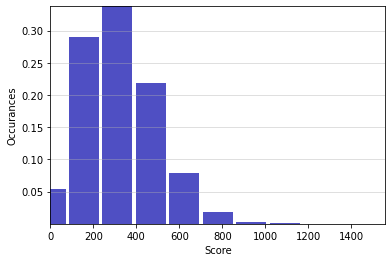

In [ ]:
gen_hist, gen_bin_edges = np.histogram(gfr)
gen_hist = (gen_hist/np.sum(gen_hist))
plot_histogram(gen_hist, gen_bin_edges)

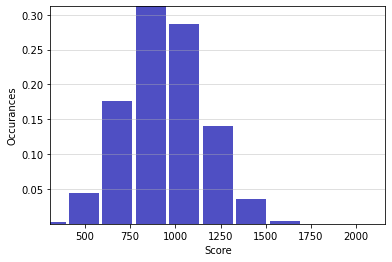

In [ ]:
imp_hist, imp_bin_edges = np.histogram(ifr)
imp_hist = imp_hist/np.sum(imp_hist)
plot_histogram(imp_hist, imp_bin_edges)

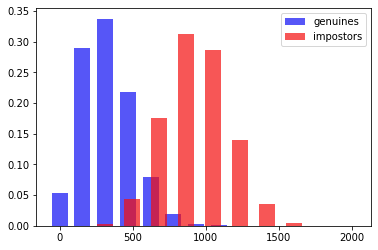

In [ ]:
plot_gen_imp([gen_hist,imp_hist],[gen_bin_edges,imp_bin_edges])

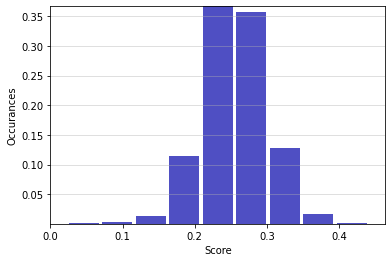

In [ ]:
gc, gcb = np.histogram(gcfr)
gc = gc/np.sum(gc)
plot_histogram(gc,gcb)

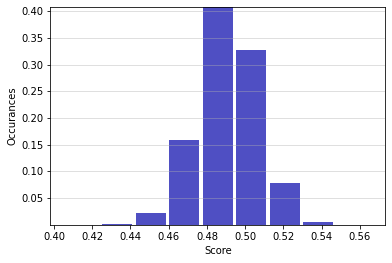

In [ ]:
ic, icb = np.histogram(icfr)
ic = ic/np.sum(ic)
plot_histogram(ic,icb)

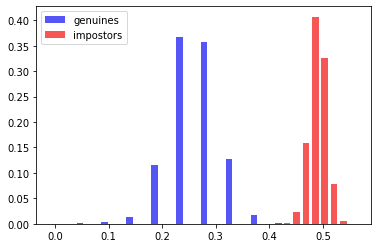

In [ ]:
plot_gen_imp([gc,ic],[gcb,icb])

In [ ]:
write_to_excel([gfr,gcfr], gpfr, [ifr,icfr], ipfr,filename='FCGlint360k(R=1.0).xlsx')

In [ ]:
!cp FCGlint360k\(R\=1.0\).xlsx /gdrive/MyDrive/colab_matches

## Loading FaceNet to receive images and align with MTCNN

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!cp /gdrive/MyDrive/facenet/facenet.zip .

In [ ]:
with zipfile.ZipFile('facenet.zip','r') as fnet:
  fnet.extractall()

In [ ]:
#!pip install tf-slim

### Copy and Extract NIST-SD32 Images

In [ ]:
!cp -r /gdrive/Shareddrives/Charlie/Datasets/Faces\ Nist-sd32 .
!mv Faces\ Nist-sd32 sd32

### Copy and Extract DoD Images

In [ ]:
!cp /gdrive/Shareddrives/Charlie/Datasets/DoD\ -\ Face\ Original/images.zip .
!mv images.zip dod.zip

In [ ]:
with zipfile.ZipFile('dod.zip','r') as dod:
  dod.extractall(path='dod')

In [ ]:
?zipfile.ZipFile.extractall

### Copy and Extract FEI Images

In [ ]:
!cp /gdrive/Shareddrives/Charlie/Datasets/FEI\ -\ Face/images.zip .
!mv images.zip fei.zip

In [ ]:
with zipfile.ZipFile('fei.zip','r') as fei:
  fei.extractall(path='fei')

### Set PYTHONPATH to use facenet

In [ ]:
#Set python path to use facenet
%env PYTHONPATH=/env/python:facenet/src

env: PYTHONPATH=/env/python:facenet/src


In [ ]:
#!python facenet/src/align/align_dataset_mtcnn.py /content/sd32 /content/sd32a

from scipy import misc
import imageio
import sys
import os
import tensorflow as tf
import numpy as np
import facenet.src.facenet as fnet
import facenet.src.align.detect_face as detect_face
from facenet.src.facenet import ImageClass
import random
import cv2
from skimage import transform as trans

In [ ]:
def get_dataset(input, sep='-'):
  dataset = []
  class_dict = {}

  files = os.listdir(input)
  for f in files:
    class_name = f.split(sep)[0]
    class_dict.setdefault(class_name,[])
    class_dict[class_name] += [os.path.join(input,f)]

  for cls in class_dict:
    dataset.append(ImageClass(cls,class_dict[cls]))

  return dataset

def align_face(img, landmarks, shape=(112,112)): #landmarks should be float32
  dst = np.array([[30.2946, 51.6963],
                  [65.5318, 51.5014],
                  [48.0252, 71.7366],
                  [33.5493, 92.3655],
                  [62.7299, 92.2041]], dtype=np.float32)

  dst[:,0] += 8.0
  tform = trans.SimilarityTransform()
  tform.estimate(landmarks,dst)
  M = tform.params[0:2, :]
  img = cv2.warpAffine(img, M, shape, borderValue=0.0)
  return img

In [ ]:
def show_aligned_face(img,landmarks,shape=(112,112)):
  x = landmarks[:,0]
  y = landmarks[:,1]

  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.scatter(x,y,c='r')

  print(img.shape)
  aligned = align_face(img,landmarks,shape)
  plt.subplot(1,2,2)
  plt.imshow(aligned)

def show_aligned_and_marked(img,landmarks,shape=(112,112)):
  dst = np.array([[30.2946, 51.6963],
                  [65.5318, 51.5014],
                  [48.0252, 71.7366],
                  [33.5493, 92.3655],
                  [62.7299, 92.2041]], dtype=np.float32)
  dst[:,0] += 8.0

  scatter_x = dst[:,0]
  scatter_y = dst[:,1]
  
  x = landmarks[:,0]
  y = landmarks[:,1]

  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.scatter(x,y,c='r')
  aligned = align_face(img,landmarks,shape)

  plt.subplot(1,2,2)
  plt.imshow(aligned)
  plt.scatter(scatter_x,scatter_y,c='r')

  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.scatter(x,y,c='g')
  aligned = align_face(img,landmarks, img.shape[:-1])
  plt.subplot(1,2,2)
  plt.imshow(aligned[:120,:120,:])
  plt.scatter(scatter_x,scatter_y,c='g')


### Utils

In [ ]:
def align_dataset(data, output_dir='aligned', margin=20):
  os.makedirs(output_dir,exist_ok=True)
  # margin = 20
  face_data = [] #cropped
  face_original = [] #non-cropped
  face_label = []
  face_confidence = []

  with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
      pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

    minsize = 20
    threshold = [ 0.6, 0.7, 0.7 ] #pnet, rnet and onet thresholds, respectively
    factor = 0.709 #scale factor

    nrof_images_total = 0
    nrof_successfully_aligned = 0
    for cls in data:
      for image_path in cls.image_paths:
        nrof_images_total += 1
        filename = os.path.basename(image_path)
        output_filename = os.path.join(output_dir,filename)
        print(image_path)
        try:
          img = imageio.imread(image_path)
        except (IOError,ValueError,IndexError) as e:
          errorMessage = '{}: {}'.format(image_path, e)
          print(errorMessage)

        else:
          if img.ndim < 2:
            print('Unable to align {}'.format(image_path))
            continue
          if img.ndim == 2:
            img = fnet.to_rgb(img)
          img = img[:,:,0:3]

          bounding_boxes, landmarks = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
          nrof_faces = bounding_boxes.shape[0]

          if nrof_faces>0:
            # print('Bounding Box Shape: {}\nBounding Box: {}'.format(bounding_boxes.shape,bounding_boxes))
            # print('Landmarks Shape: {}\nLandmarks: {}'.format(landmarks.shape,landmarks))
            det = bounding_boxes[:,:]
            det_arr = []
            img_size = np.asarray(img.shape)[0:2]
            if nrof_faces > 1:
              bounding_box_size = (det[:,2]-det[:,0])*(det[:,3]-det[:,1])
              img_center = img_size / 2
              offsets = np.vstack([ (det[:,0]+det[:,2])/2-img_center[1], (det[:,1]+det[:,3])/2-img_center[0] ])
              offset_dist_squared = np.sum(np.power(offsets,2.0),0)
              index = np.argmax(bounding_box_size-offset_dist_squared*2.0)
              det_arr.append(det[index,:])
              # print('Landmarks Shape: {}\n Landmarks: {}'.format(landmarks.shape,landmarks))
              landmarks = landmarks[:,index]
            else:
              det_arr.append(np.squeeze(det))

            for i, det in enumerate(det_arr):
              det = np.squeeze(det)
              bb = np.zeros(4, dtype=np.int32)
              bb[0] = np.maximum(det[0]-margin/2, 0)
              bb[1] = np.maximum(det[1]-margin/2, 0)
              bb[2] = np.minimum(det[2]+margin/2, img_size[1])
              bb[3] = np.minimum(det[3]+margin/2, img_size[0])
              cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
              ldmk = np.squeeze(np.array(landmarks))
              np_landmarks = np.empty((5,2))
              for i in range(ldmk.shape[0]//2):
                # np_landmarks[i] = [ldmk[i]-bb[0],ldmk[i+5]-bb[1]]
                np_landmarks[i] = [ldmk[i],ldmk[i+5]]

              face_data.append([cropped,np_landmarks-[bb[0],bb[1]]])
              face_original.append([img,np_landmarks])
              face_label.append([cls.name])
              face_confidence.append([det[4]])
              
              aligned = align_face(img,np_landmarks)
              nrof_successfully_aligned += 1

              imageio.imsave(output_filename, aligned)            

    print('Number of images: {}'.format(nrof_images_total))
    print('Number of aligned images: {}'.format(nrof_successfully_aligned))

  return face_data, face_original, face_label, face_confidence # face data = [MTCNN cropped, landmarks on current crop]; face_original = [original img, original_landmarks]; face_confidence = [face_confidence]

In [ ]:
def read_pairs(pair_file, templates, group=''):
  lines = []
  pairs = []
  skipped = 0
  with open(pair_file,'r') as f:
    path = f.readline()
    lines = f.readlines()
    lines = [line for line in lines]

  for idx, pair in enumerate(lines):
    if pair == '':
      continue
    p1, p2 = pair.split()
    idx1 = -1
    idx2 = -1
    for it, template in enumerate(templates):
      basename = os.path.splitext(template.filename)[0]
      if os.path.splitext(p1)[0] == basename:
        idx1 = it
      if os.path.splitext(p2)[0] == basename:
        idx2 = it
      if not idx1 == -1 and not idx2 == -1:
        break
    if idx1 == -1 or idx2 == -1:
      # raise NameError('Invalid Template on List. idx1: {}, idx2: {}'.format(idx1,idx2))
      print('Pair info:\n\t{} {}\n\t{} {}'.format(
          p1,
          '(found)' if not idx1==-1 else '(not found)',
          p2,
          '(found)' if not idx2==-1 else '(not found)'))
      skipped += 1
      continue

    pairs += [(idx1,idx2)]

  return pairs, skipped

In [ ]:
def write_compare_results(templates,gen_pairs_idx,imp_pairs_idx,gen_file='match_gen_results.txt',imp_file='match_imp_results.txt'):
  with open(gen_file,'w') as f:
    gen_idx = 0
    for idx1, idx2 in gen_pairs_idx:
      f.write('{} {} {} {:.2f}\n'.format(
          gen_idx,
          templates[idx1].filename, 
          templates[idx2].filename, 
          1 - cosine_dist(templates[idx1],templates[idx2])[0]))
      gen_idx+=1

  with open(imp_file,'w') as f:
    imp_idx = 0
    for idx1, idx2 in imp_pairs_idx:
      f.write('{} {} {} {:.2f}\n'.format(
          imp_idx,
          templates[idx1].filename, 
          templates[idx2].filename, 
          1 - cosine_dist(templates[idx1],templates[idx2])[0]))
      imp_idx+=1

### Align Datasets with MTCNN

#### NIST-SD32

In [ ]:
data = get_dataset('sd32')


In [ ]:
data[0].image_paths
face_data, face_original, face_label, _ = align_dataset(data)





Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

sd32/S015-03-t10_01.jpg
sd32/S015-01-t10_01.jpg
sd32/S015-02-t10_01.jpg
sd32/S440-02-t10_01.jpg
sd32/S440-03-t10_01.jpg
sd32/S440-04-t10_01.jpg
sd32/S440-01-t10_01.jpg
sd32/S440-05-t10_01.jpg
sd32/S208-01-t10_01.jpg
sd32/S044-02-t10_01.jpg
sd32/S044-09-t10_01.jpg
sd32/S044-03-t10_01.jpg
sd32/S044-05-t10_01.jpg
sd32/S044-07-t10_01.jpg
sd32/S044-06-t10_01.jpg
sd32/S044-04-t10_01.jpg
sd32/S044-08-t10_01.jpg
sd32/S044-01-t10_01.jpg
sd32/S376-02-t10_01.jpg
sd32/S376-01-t10_01.jpg
sd32/S376-03-t10_01.jpg
sd32/S028-01-t10_01.jpg
sd32/S078-03-t10_01.jpg
sd32/S078-04-t10_01.jpg
sd32/S078-02-t10_01.jpg
sd32/S078-01-t10_01.jpg
sd32/S316-02-t10_01.jpg
sd32/S316-06-t10_01.jpg
sd32/S316-03-t10_01.jpg
sd32/S316-04-t10_01.jpg
sd32/S316-08-t10_01.jpg
sd32/S316-05-t10_01.jpg
sd32/S316-07-t10_01.jpg
sd32/S316-01-t10_01.jpg
sd32/S466-04-t10_01.jpg
sd32/S466-05-t10_01.jpg
sd32/S466-02-t10_01.jpg
sd32/S466-03-t10_01.jpg
sd32/

#### DoD

In [ ]:
dod_data = get_dataset('dod',sep='_')
dod_face_data, dod_face_original, dod_face_label, _ = align_dataset(dod_data,output_dir='dod_aligned')

dod/988_1.jpg
dod/988_0.jpg
dod/334_1.jpg
dod/334_2.jpg
dod/334_0.jpg
dod/428_2.jpg
dod/428_1.jpg
dod/428_0.jpg
dod/365_1.jpg
dod/365_0.jpg
dod/365_2.jpg
dod/565_1.jpg
dod/565_0.jpg
dod/565_2.jpg
dod/865_1.jpg
dod/865_0.jpg
dod/456_2.jpg
dod/456_0.jpg
dod/456_1.jpg
dod/519_1.jpg
dod/519_0.jpg
dod/519_2.jpg
dod/147_0.jpg
dod/147_1.jpg
dod/147_2.jpg
dod/342_1.jpg
dod/342_0.jpg
dod/342_2.jpg
dod/257_2.jpg
dod/257_1.jpg
dod/257_0.jpg
dod/807_0.jpg
dod/807_1.jpg
dod/273_0.jpg
dod/273_1.jpg
dod/273_2.jpg
dod/68_2.jpg
dod/68_0.jpg
dod/68_1.jpg
dod/432_0.jpg
dod/432_1.jpg
dod/432_2.jpg
dod/284_2.jpg
dod/284_0.jpg
dod/284_1.jpg
dod/970_1.jpg
dod/970_0.jpg
dod/528_2.jpg
dod/528_0.jpg
dod/528_1.jpg
dod/859_0.jpg
dod/859_1.jpg
dod/99_1.jpg
dod/99_2.jpg
dod/99_0.jpg
dod/336_0.jpg
dod/336_1.jpg
dod/336_2.jpg
dod/849_0.jpg
dod/849_1.jpg
dod/967_1.jpg
dod/967_0.jpg
dod/1043_0.jpg
dod/67_1.jpg
dod/67_2.jpg
dod/67_0.jpg
dod/23_1.jpg
dod/23_2.jpg
dod/23_0.jpg
dod/23_3.jpg
dod/804_1.jpg
dod/804_0.jpg
dod/

#### FEI

In [ ]:
fei_data = get_dataset('fei')
fei_face_data, fei_face_original, fei_labels, fei_confidence = align_dataset(fei_data,output_dir='fei_aligned')

fei/35-08.jpg
fei/35-09.jpg
fei/35-10.jpg
fei/35-05.jpg
fei/35-13.jpg
fei/35-02.jpg
fei/35-11.jpg
fei/35-12.jpg
fei/35-01.jpg
fei/35-07.jpg
fei/35-04.jpg
fei/35-03.jpg
fei/35-14.jpg
fei/35-06.jpg
fei/121-13.jpg
fei/121-05.jpg
fei/121-14.jpg
fei/121-04.jpg
fei/121-08.jpg
fei/121-12.jpg
fei/121-01.jpg
fei/121-06.jpg
fei/121-09.jpg
fei/121-02.jpg
fei/121-03.jpg
fei/121-10.jpg
fei/121-07.jpg
fei/121-11.jpg
fei/51-01.jpg
fei/51-04.jpg
fei/51-02.jpg
fei/51-08.jpg
fei/51-03.jpg
fei/51-14.jpg
fei/51-12.jpg
fei/51-06.jpg
fei/51-11.jpg
fei/51-05.jpg
fei/51-13.jpg
fei/51-10.jpg
fei/51-09.jpg
fei/51-07.jpg
fei/79-03.jpg
fei/79-01.jpg
fei/79-05.jpg
fei/79-09.jpg
fei/79-10.jpg
fei/79-02.jpg
fei/79-12.jpg
fei/79-07.jpg
fei/79-13.jpg
fei/79-14.jpg
fei/79-08.jpg
fei/79-11.jpg
fei/79-06.jpg
fei/79-04.jpg
fei/56-06.jpg
fei/56-14.jpg
fei/56-03.jpg
fei/56-11.jpg
fei/56-05.jpg
fei/56-04.jpg
fei/56-02.jpg
fei/56-07.jpg
fei/56-10.jpg
fei/56-08.jpg
fei/56-09.jpg
fei/56-13.jpg
fei/56-12.jpg
fei/56-01.jpg
fei/84

(600, 480, 3)


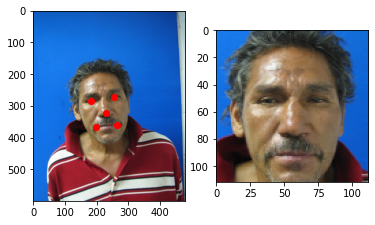

In [ ]:
img, land = random.sample(face_original,1)[0]
show_aligned_face(img,land)

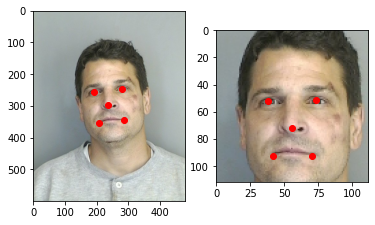

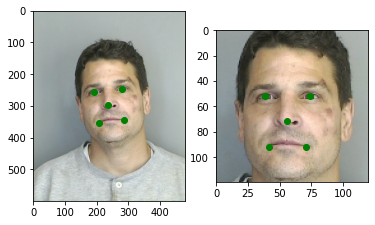

In [ ]:
show_aligned_and_marked(img,land)

### Extract NIST-SD32 Templates

In [ ]:
nist_label = []
nist_images_path = []
for lbl in data:
  nist_label += [lbl.name]
  aligned_paths = []
  for img_path in lbl.image_paths:
    aligned_path = os.path.basename(img_path)
    aligned_path = os.path.join('aligned',aligned_path)
    aligned_paths += [aligned_path]

  nist_images_path += [aligned_paths]

print(nist_images_path)

[['aligned/S075-01-t10_01.jpg'], ['aligned/S322-01-t10_01.jpg'], ['aligned/S256-01-t10_01.jpg', 'aligned/S256-02-t10_01.jpg'], ['aligned/S440-01-t10_01.jpg', 'aligned/S440-04-t10_01.jpg', 'aligned/S440-03-t10_01.jpg', 'aligned/S440-02-t10_01.jpg', 'aligned/S440-05-t10_01.jpg'], ['aligned/S115-01-t10_01.jpg'], ['aligned/S403-03-t10_01.jpg', 'aligned/S403-01-t10_01.jpg', 'aligned/S403-04-t10_01.jpg', 'aligned/S403-02-t10_01.jpg'], ['aligned/S472-03-t10_01.jpg', 'aligned/S472-01-t10_01.jpg', 'aligned/S472-02-t10_01.jpg'], ['aligned/S171-02-t10_01.jpg', 'aligned/S171-08-t10_01.jpg', 'aligned/S171-05-t10_01.jpg', 'aligned/S171-01-t10_01.jpg', 'aligned/S171-03-t10_01.jpg', 'aligned/S171-07-t10_01.jpg', 'aligned/S171-06-t10_01.jpg', 'aligned/S171-04-t10_01.jpg'], ['aligned/S314-01-t10_01.jpg'], ['aligned/S215-01-t10_01.jpg', 'aligned/S215-04-t10_01.jpg', 'aligned/S215-02-t10_01.jpg', 'aligned/S215-03-t10_01.jpg'], ['aligned/S226-01-t10_01.jpg', 'aligned/S226-02-t10_01.jpg'], ['aligned/S253-02

In [ ]:
nist_templates = extract_templates(fr_mod,nist_label,nist_images_path)

### Extract DoD Templates

In [ ]:
dod_label = []
dod_images_path = []
for lbl in dod_data:
  dod_label += [lbl.name]
  aligned_paths = []
  for img_path in lbl.image_paths:
    aligned_path = os.path.basename(img_path)
    aligned_path = os.path.join('dod_aligned', aligned_path)
    aligned_paths += [aligned_path]

  dod_images_path += [aligned_paths]

print(dod_images_path)

[['dod_aligned/988_1.jpg', 'dod_aligned/988_0.jpg'], ['dod_aligned/334_1.jpg', 'dod_aligned/334_2.jpg', 'dod_aligned/334_0.jpg'], ['dod_aligned/428_2.jpg', 'dod_aligned/428_1.jpg', 'dod_aligned/428_0.jpg'], ['dod_aligned/365_1.jpg', 'dod_aligned/365_0.jpg', 'dod_aligned/365_2.jpg'], ['dod_aligned/565_1.jpg', 'dod_aligned/565_0.jpg', 'dod_aligned/565_2.jpg'], ['dod_aligned/865_1.jpg', 'dod_aligned/865_0.jpg'], ['dod_aligned/456_2.jpg', 'dod_aligned/456_0.jpg', 'dod_aligned/456_1.jpg'], ['dod_aligned/519_1.jpg', 'dod_aligned/519_0.jpg', 'dod_aligned/519_2.jpg'], ['dod_aligned/147_0.jpg', 'dod_aligned/147_1.jpg', 'dod_aligned/147_2.jpg'], ['dod_aligned/342_1.jpg', 'dod_aligned/342_0.jpg', 'dod_aligned/342_2.jpg'], ['dod_aligned/257_2.jpg', 'dod_aligned/257_1.jpg', 'dod_aligned/257_0.jpg'], ['dod_aligned/807_0.jpg', 'dod_aligned/807_1.jpg'], ['dod_aligned/273_0.jpg', 'dod_aligned/273_1.jpg', 'dod_aligned/273_2.jpg'], ['dod_aligned/68_2.jpg', 'dod_aligned/68_0.jpg', 'dod_aligned/68_1.jpg'],

In [ ]:
dod_templates = extract_templates(fr_mod,dod_label,dod_images_path)

### Extract FEI Templates

In [ ]:
fei_label = []
fei_images_path = []
for lbl in fei_data:
  fei_label += [lbl.name]
  aligned_paths = []
  for img_path in lbl.image_paths:
    aligned_path = os.path.basename(img_path)
    aligned_path = os.path.join('fei_aligned',aligned_path)
    aligned_paths += [aligned_path]

  fei_images_path += [aligned_paths]

print(fei_images_path)

[['fei_aligned/35-08.jpg', 'fei_aligned/35-09.jpg', 'fei_aligned/35-10.jpg', 'fei_aligned/35-05.jpg', 'fei_aligned/35-13.jpg', 'fei_aligned/35-02.jpg', 'fei_aligned/35-11.jpg', 'fei_aligned/35-12.jpg', 'fei_aligned/35-01.jpg', 'fei_aligned/35-07.jpg', 'fei_aligned/35-04.jpg', 'fei_aligned/35-03.jpg', 'fei_aligned/35-14.jpg', 'fei_aligned/35-06.jpg'], ['fei_aligned/121-13.jpg', 'fei_aligned/121-05.jpg', 'fei_aligned/121-14.jpg', 'fei_aligned/121-04.jpg', 'fei_aligned/121-08.jpg', 'fei_aligned/121-12.jpg', 'fei_aligned/121-01.jpg', 'fei_aligned/121-06.jpg', 'fei_aligned/121-09.jpg', 'fei_aligned/121-02.jpg', 'fei_aligned/121-03.jpg', 'fei_aligned/121-10.jpg', 'fei_aligned/121-07.jpg', 'fei_aligned/121-11.jpg'], ['fei_aligned/51-01.jpg', 'fei_aligned/51-04.jpg', 'fei_aligned/51-02.jpg', 'fei_aligned/51-08.jpg', 'fei_aligned/51-03.jpg', 'fei_aligned/51-14.jpg', 'fei_aligned/51-12.jpg', 'fei_aligned/51-06.jpg', 'fei_aligned/51-11.jpg', 'fei_aligned/51-05.jpg', 'fei_aligned/51-13.jpg', 'fei_

In [ ]:
fei_templates = extract_templates(fr_mod,fei_label,fei_images_path)

Extracting Templates with label 35 (1 out of 200)
Extracting Templates with label 121 (2 out of 200)
Extracting Templates with label 51 (3 out of 200)
Extracting Templates with label 79 (4 out of 200)
Extracting Templates with label 56 (5 out of 200)
Extracting Templates with label 84 (6 out of 200)
Extracting Templates with label 113 (7 out of 200)
Extracting Templates with label 103 (8 out of 200)
Extracting Templates with label 164 (9 out of 200)
Extracting Templates with label 109 (10 out of 200)
Extracting Templates with label 133 (11 out of 200)
Extracting Templates with label 60 (12 out of 200)
Extracting Templates with label 40 (13 out of 200)
Extracting Templates with label 23 (14 out of 200)
Extracting Templates with label 135 (15 out of 200)
Extracting Templates with label 99 (16 out of 200)
Extracting Templates with label 11 (17 out of 200)
Extracting Templates with label 24 (18 out of 200)
Extracting Templates with label 9 (19 out of 200)
Extracting Templates with label 14

### Evaluate NIST-SD32 Pairs


In [ ]:
!cp -r /gdrive/MyDrive/pairs/NISTSD32/ .

In [ ]:
gen_pairs = []
imp_pairs = []

with open('NISTSD32/ftg_gen_matchlist.txt') as f:
  path = f.readline()
  lines = f.read()
  gen_pairs = [line for line in lines.split('\n')]

with open('NISTSD32/ftg_imp_matchlist.txt') as f:
  path = f.readline()
  lines = f.read()
  imp_pairs = [line for line in lines.split('\n')]

In [ ]:
gen_pairs_idx = []
imp_pairs_idx = []
gen_skipped_pairs = 0
imp_skipped_pairs = 0

for idx, pair in enumerate(gen_pairs):
  if pair == '':
    continue
  p1, p2 = pair.split()
  idx1 = -1
  idx2 = -1
  for it, template in enumerate(nist_templates):
    basename = os.path.splitext(template.filename)[0]
    if os.path.splitext(p1)[0] == basename:
      idx1 = it
    if os.path.splitext(p2)[0] == basename:
      idx2 = it
    if not idx1 == -1 and not idx2 == -1:
      break
  if idx1 == -1 or idx2 == -1:
    # raise NameError('Invalid Template on List. idx1: {}, idx2: {}'.format(idx1,idx2))
    print('Pair info:\n\t{} {}\n\t{} {}'.format(
        p1,
        '(found)' if not idx1==-1 else '(not found)',
        p2,
        '(found)' if not idx2==-1 else '(not found)'))
    gen_skipped_pairs += 1
    continue

  gen_pairs_idx += [(idx1,idx2)]

for idx, pair in enumerate(imp_pairs):
  if pair == '':
    continue
  p1, p2 = pair.split()
  idx1 = -1
  idx2 = -1
  for it, template in enumerate(nist_templates):
    basename = os.path.splitext(template.filename)[0]
    if os.path.splitext(p1)[0] == basename:
      idx1 = it
    if os.path.splitext(p2)[0] == basename:
      idx2 = it
    if not idx1 == -1 and not idx2 == -1:
      break
  
  if idx1 == -1 or idx2 == -1:
    # raise NameError('Invalid Template on List')
    print('Pair info:\n\t{} {}\n\t{} {}'.format(
        p1,
        '(found)' if not idx1==-1 else '(not found)',
        p2,
        '(found)' if not idx2==-1 else '(not found)'))
    imp_skipped_pairs += 1
    continue

  imp_pairs_idx += [(idx1,idx2)]

print('Genuines Skipped Pairs = {}'.format(gen_skipped_pairs))
print('Impostors Skipped Pairs = {}'.format(imp_skipped_pairs))

Pair info:
	S300-01-t10_01.ftg (not found)
	S300-02-t10_01.ftg (found)
Pair info:
	S300-02-t10_01.ftg (found)
	S300-01-t10_01.ftg (not found)
Pair info:
	S446-01-t10_01.ftg (found)
	S446-02-t10_01.ftg (not found)
Pair info:
	S446-02-t10_01.ftg (not found)
	S446-01-t10_01.ftg (found)
Pair info:
	S466-01-t10_01.ftg (not found)
	S466-02-t10_01.ftg (found)
Pair info:
	S466-01-t10_01.ftg (not found)
	S466-03-t10_01.ftg (found)
Pair info:
	S466-01-t10_01.ftg (not found)
	S466-04-t10_01.ftg (found)
Pair info:
	S466-01-t10_01.ftg (not found)
	S466-05-t10_01.ftg (found)
Pair info:
	S466-01-t10_01.ftg (not found)
	S466-06-t10_01.ftg (found)
Pair info:
	S466-02-t10_01.ftg (found)
	S466-01-t10_01.ftg (not found)
Pair info:
	S466-03-t10_01.ftg (found)
	S466-01-t10_01.ftg (not found)
Pair info:
	S466-04-t10_01.ftg (found)
	S466-01-t10_01.ftg (not found)
Pair info:
	S466-05-t10_01.ftg (found)
	S466-01-t10_01.ftg (not found)
Pair info:
	S466-06-t10_01.ftg (found)
	S466-01-t10_01.ftg (not found)
Pair i

In [ ]:
print(gen_pairs_idx[:5])
print(imp_pairs_idx[:5])

[(257, 264), (257, 256), (257, 261), (257, 259), (257, 260)]
[(257, 913), (257, 612), (257, 1196), (257, 775), (257, 1056)]


#### Using GLINT360K R=1.0 model


In [ ]:
gen_eu = []
imp_eu = []
gen_cos = []
imp_cos = []

for idx1, idx2 in gen_pairs_idx:
  gen_eu += [euclidean_dist(nist_templates[idx1],nist_templates[idx2])[0]]
  gen_cos += [cosine_dist(nist_templates[idx1],nist_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_idx:
  imp_eu += [euclidean_dist(nist_templates[idx1],nist_templates[idx2])[0]]
  imp_cos += [cosine_dist(nist_templates[idx1],nist_templates[idx2])[0]]

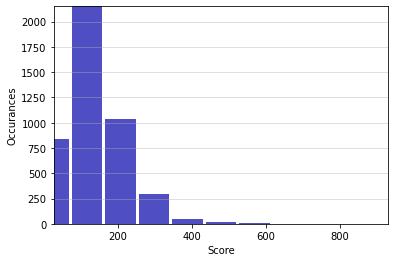

In [ ]:
ng, ngb = np.histogram(gen_eu)
plot_histogram(ng,ngb)

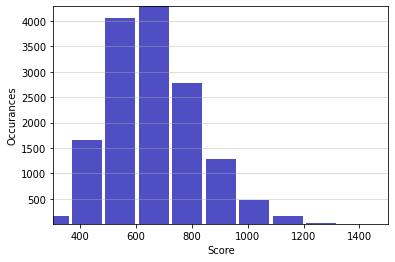

In [ ]:
ni, nib = np.histogram(imp_eu)
plot_histogram(ni,nib)

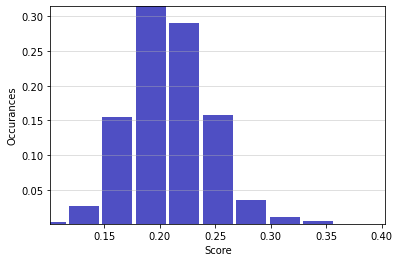

In [ ]:
ngc, ngcb = np.histogram(gen_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

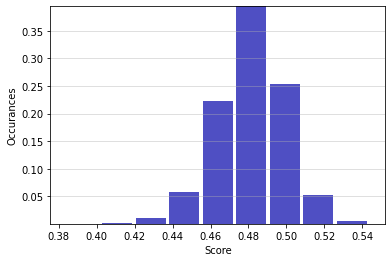

In [ ]:
nic, nicb = np.histogram(imp_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

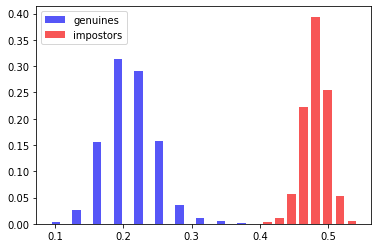

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
with open('gen_results.txt','w') as f:
  for idx1, idx2 in gen_pairs_idx:
    f.write('{}\t{}\t{:.2f}\t{:.2f}\n'.format(
        nist_templates[idx1].filename, 
        nist_templates[idx2].filename, 
        euclidean_dist(nist_templates[idx1],nist_templates[idx2])[0], 
        cosine_dist(nist_templates[idx1],nist_templates[idx2])[0]))

In [ ]:
write_compare_results(nist_templates,gen_pairs_idx,imp_pairs_idx)

#### Using the OPENVINO model


In [ ]:
nistv_templates = extract_templates(mod,nist_label,nist_images_path)

Extracting Templates with label S075 (1 out of 518)
Extracting Templates with label S322 (2 out of 518)
Extracting Templates with label S256 (3 out of 518)
Extracting Templates with label S440 (4 out of 518)
Extracting Templates with label S115 (5 out of 518)
Extracting Templates with label S403 (6 out of 518)
Extracting Templates with label S472 (7 out of 518)
Extracting Templates with label S171 (8 out of 518)
Extracting Templates with label S314 (9 out of 518)
Extracting Templates with label S215 (10 out of 518)
Extracting Templates with label S226 (11 out of 518)
Extracting Templates with label S253 (12 out of 518)
Extracting Templates with label S044 (13 out of 518)
Extracting Templates with label S197 (14 out of 518)
Extracting Templates with label S382 (15 out of 518)
Extracting Templates with label S388 (16 out of 518)
Extracting Templates with label S497 (17 out of 518)
Extracting Templates with label S476 (18 out of 518)
Extracting Templates with label S415 (19 out of 518)
Ex

In [ ]:
ov_gen_eu = []
ov_imp_eu = []
ov_gen_cos = []
ov_imp_cos = []

for idx1, idx2 in gen_pairs_idx:
  ov_gen_eu += [euclidean_dist(nistv_templates[idx1],nistv_templates[idx2])[0]]
  ov_gen_cos += [cosine_dist(nistv_templates[idx1],nistv_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_idx:
  ov_imp_eu += [euclidean_dist(nistv_templates[idx1],nistv_templates[idx2])[0]]
  ov_imp_cos += [cosine_dist(nistv_templates[idx1],nistv_templates[idx2])[0]]

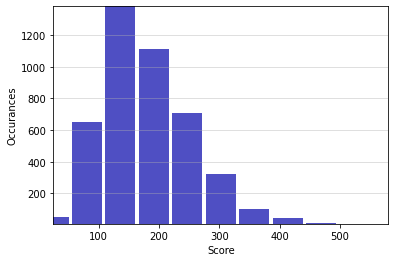

In [ ]:
ng, ngb = np.histogram(ov_gen_eu)
plot_histogram(ng,ngb)

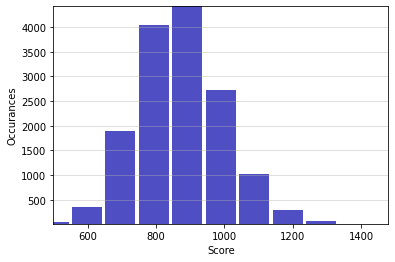

In [ ]:
ni, nib = np.histogram(ov_imp_eu)
plot_histogram(ni,nib)

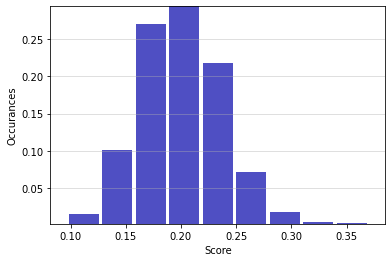

In [ ]:
ngc, ngcb = np.histogram(ov_gen_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

In [ ]:
max(ngcb)

0.38504943

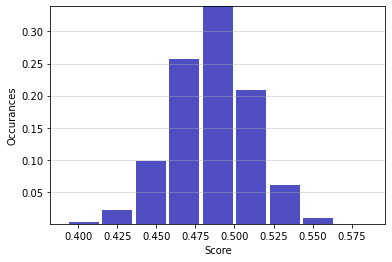

In [ ]:
nic, nicb = np.histogram(ov_imp_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

In [ ]:
min(nicb)

0.38227075

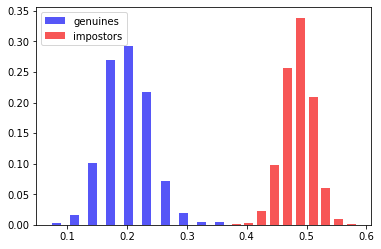

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
write_compare_results(nistv_templates,gen_pairs_idx,imp_pairs_idx,gen_file='match_vino_gen_results.txt',imp_file='match_vino_imp_results.txt')

### Evaluate DoD Pairs

In [ ]:
!cp -r /gdrive/MyDrive/pairs/BASED .

In [ ]:
gen_pairs_id, gen_pairs_skipped =  read_pairs('BASED/ftg_gen_dod_matchlist.txt', dod_templates)
imp_pairs_id, imp_pairs_skipped = read_pairs('BASED/ftg_imp_dod_matchlist.txt', dod_templates)

print('Genuines Skipped Pairs: {}'.format(gen_pairs_skipped))
print('Impostors Skipped Pairs: {}'.format(imp_pairs_skipped))

Pair info:
	247_0.ftg (found)
	247_1.ftg (not found)
Pair info:
	247_1.ftg (not found)
	247_2.ftg (found)
Pair info:
	1019_0.ftg (not found)
	624_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	386_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	562_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	269_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	857_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	882_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	185_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	911_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	818_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	960_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	869_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	517_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	427_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	889_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	865_0.ftg (found)
Pair info:
	1019_0.ftg (not found)
	972_0.ftg (found)
Pair info:
	1019_0.ftg (not fo

#### Using GLINT360K R=1.0 model

In [ ]:
gen_eu = []
imp_eu = []
gen_cos = []
imp_cos = []

for idx1, idx2 in gen_pairs_id:
  gen_eu += [euclidean_dist(dod_templates[idx1],dod_templates[idx2])[0]]
  gen_cos += [cosine_dist(dod_templates[idx1],dod_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_id:
  imp_eu += [euclidean_dist(dod_templates[idx1],dod_templates[idx2])[0]]
  imp_cos += [cosine_dist(dod_templates[idx1],dod_templates[idx2])[0]]

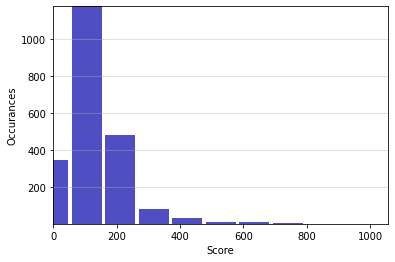

In [ ]:
ng, ngb = np.histogram(gen_eu)
plot_histogram(ng,ngb)

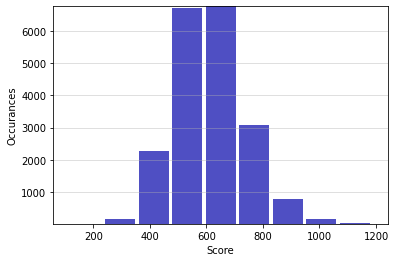

In [ ]:
ni, nib = np.histogram(imp_eu)
plot_histogram(ni,nib)

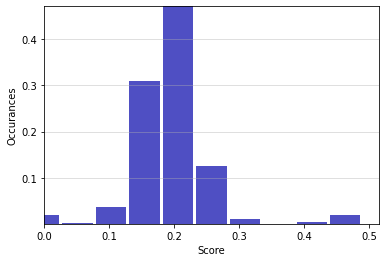

In [ ]:
ngc, ngcb = np.histogram(gen_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

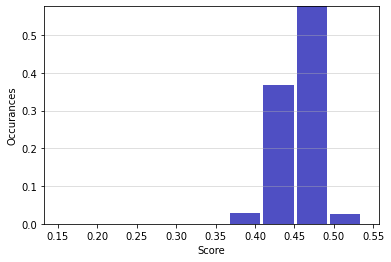

In [ ]:
nic, nicb = np.histogram(imp_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

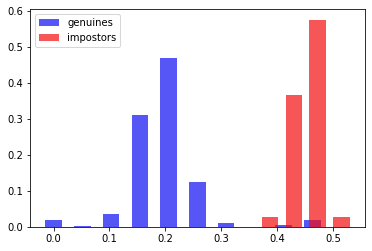

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
write_compare_results(dod_templates,gen_pairs_id,imp_pairs_id,gen_file='compare_gen_dod_glint.txt',imp_file='compare_imp_dod_glint.txt')

#### Using OPENVINO model

In [ ]:
dodv_templates = extract_templates(mod,dod_label, dod_images_path)

In [ ]:
genv_eu = []
impv_eu = []
genv_cos = []
impv_cos = []

for idx1, idx2 in gen_pairs_id:
  genv_eu += [euclidean_dist(dodv_templates[idx1],dodv_templates[idx2])[0]]
  genv_cos += [cosine_dist(dodv_templates[idx1],dodv_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_id:
  impv_eu += [euclidean_dist(dodv_templates[idx1],dodv_templates[idx2])[0]]
  impv_cos += [cosine_dist(dodv_templates[idx1],dodv_templates[idx2])[0]]

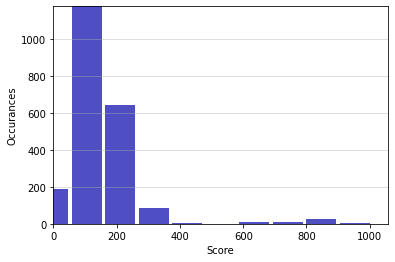

In [ ]:
ng, ngb = np.histogram(genv_eu)
plot_histogram(ng,ngb)

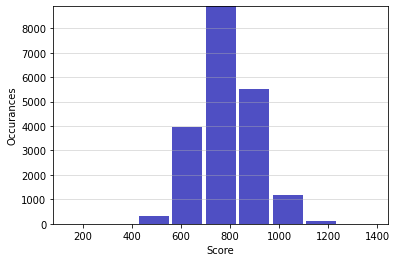

In [ ]:
ni, nib = np.histogram(impv_eu)
plot_histogram(ni,nib)

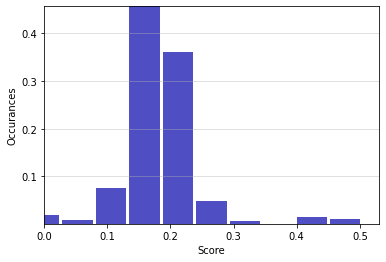

In [ ]:
ngc, ngcb = np.histogram(genv_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

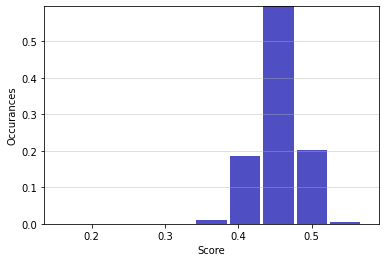

In [ ]:
nic, nicb = np.histogram(impv_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

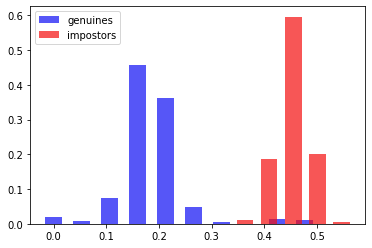

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
write_compare_results(dodv_templates,gen_pairs_id,imp_pairs_id,gen_file='compare_gen_dod_vino.txt',imp_file='compare_imp_dod_vino.txt')

### Evaluate FEI Pairs

In [ ]:
!cp -r /gdrive/MyDrive/pairs/FEI .

In [ ]:
gen_pairs_id, gen_pairs_skipped =  read_pairs('FEI/ftg_gen_matchlist.txt', fei_templates)
imp_pairs_id, imp_pairs_skipped = read_pairs('FEI/ftg_imp_matchlist.txt', fei_templates)

print('Genuines Skipped Pairs: {}'.format(gen_pairs_skipped))
print('Impostors Skipped Pairs: {}'.format(imp_pairs_skipped))

Genuines Skipped Pairs: 0
Impostors Skipped Pairs: 0


#### Using GLINT360K R=1.0 model

In [ ]:
gen_eu = []
imp_eu = []
gen_cos = []
imp_cos = []

for idx1, idx2 in gen_pairs_id:
  gen_eu += [euclidean_dist(fei_templates[idx1],fei_templates[idx2])[0]]
  gen_cos += [cosine_dist(fei_templates[idx1],fei_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_id:
  imp_eu += [euclidean_dist(fei_templates[idx1],fei_templates[idx2])[0]]
  imp_cos += [cosine_dist(fei_templates[idx1],fei_templates[idx2])[0]]

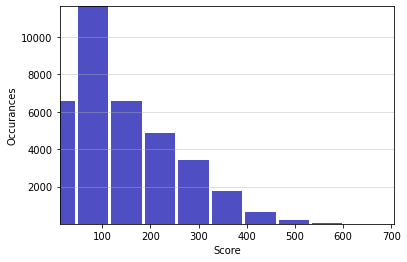

In [ ]:
ng, ngb = np.histogram(gen_eu)
plot_histogram(ng,ngb)

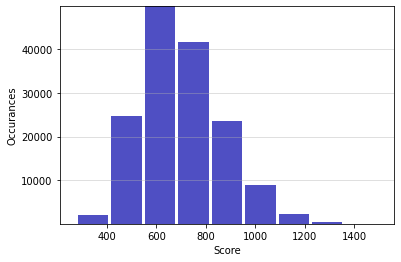

In [ ]:
ni, nib = np.histogram(imp_eu)
plot_histogram(ni,nib)

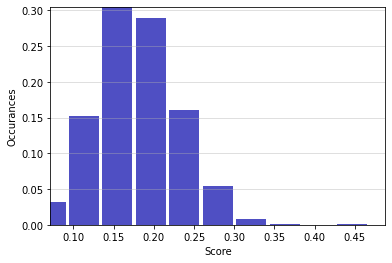

In [ ]:
ngc, ngcb = np.histogram(gen_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

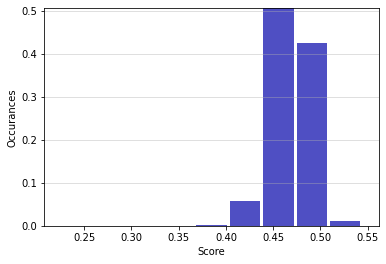

In [ ]:
nic, nicb = np.histogram(imp_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

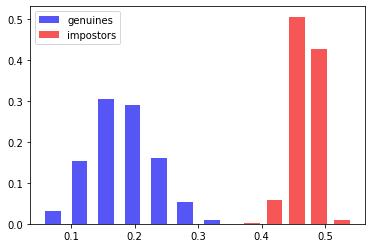

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
write_compare_results(fei_templates,gen_pairs_id,imp_pairs_id,gen_file='compare_gen_fei_glint.txt',imp_file='compare_imp_fei_glint.txt')

#### Using OPENVINO model

In [ ]:
feiv_templates = extract_templates(mod,fei_label, fei_images_path)

Extracting Templates with label 35 (1 out of 200)
Extracting Templates with label 121 (2 out of 200)
Extracting Templates with label 51 (3 out of 200)
Extracting Templates with label 79 (4 out of 200)
Extracting Templates with label 56 (5 out of 200)
Extracting Templates with label 84 (6 out of 200)
Extracting Templates with label 113 (7 out of 200)
Extracting Templates with label 103 (8 out of 200)
Extracting Templates with label 164 (9 out of 200)
Extracting Templates with label 109 (10 out of 200)
Extracting Templates with label 133 (11 out of 200)
Extracting Templates with label 60 (12 out of 200)
Extracting Templates with label 40 (13 out of 200)
Extracting Templates with label 23 (14 out of 200)
Extracting Templates with label 135 (15 out of 200)
Extracting Templates with label 99 (16 out of 200)
Extracting Templates with label 11 (17 out of 200)
Extracting Templates with label 24 (18 out of 200)
Extracting Templates with label 9 (19 out of 200)
Extracting Templates with label 14

In [ ]:
genv_eu = []
impv_eu = []
genv_cos = []
impv_cos = []

for idx1, idx2 in gen_pairs_id:
  genv_eu += [euclidean_dist(feiv_templates[idx1],feiv_templates[idx2])[0]]
  genv_cos += [cosine_dist(feiv_templates[idx1],feiv_templates[idx2])[0]]

for idx1, idx2 in imp_pairs_id:
  impv_eu += [euclidean_dist(feiv_templates[idx1],feiv_templates[idx2])[0]]
  impv_cos += [cosine_dist(feiv_templates[idx1],feiv_templates[idx2])[0]]

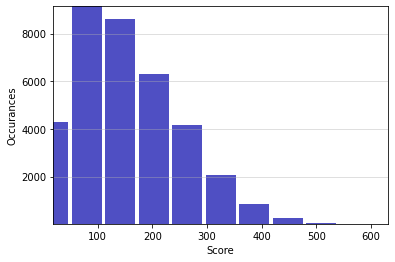

In [ ]:
ng, ngb = np.histogram(genv_eu)
plot_histogram(ng,ngb)

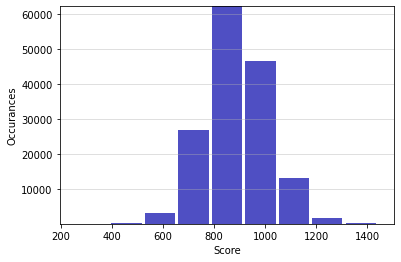

In [ ]:
ni, nib = np.histogram(impv_eu)
plot_histogram(ni,nib)

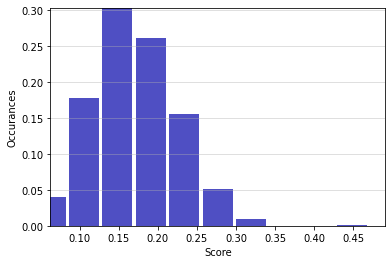

In [ ]:
ngc, ngcb = np.histogram(genv_cos)
ngc = ngc/np.sum(ngc)
plot_histogram(ngc,ngcb)

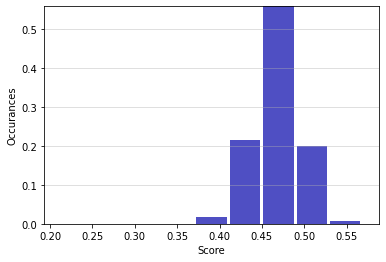

In [ ]:
nic, nicb = np.histogram(impv_cos)
nic = nic/np.sum(nic)
plot_histogram(nic,nicb)

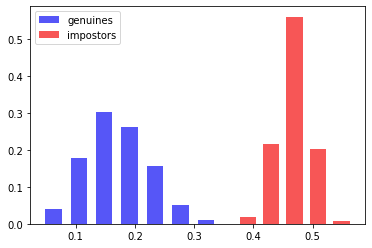

In [ ]:
plot_gen_imp([ngc,nic],[ngcb,nicb])

In [ ]:
write_compare_results(feiv_templates,gen_pairs_id,imp_pairs_id,gen_file='compare_gen_fei_vino.txt',imp_file='compare_imp_fei_vino.txt')

In [ ]:
!cp -rv fei_aligned /gdrive/MyDrive/

In [ ]:
!ls fei_aligned | grep -c ^
!ls /gdrive/MyDrive/fei_aligned | grep -c ^

2777
2777


In [ ]:
fei_aligned_images = [os.path.join('fei_aligned',f) for f in os.listdir('fei_aligned')]
with zipfile.ZipFile('fei.aligned.zip','w',zipfile.ZIP_DEFLATED) as zip:
    for img in fei_aligned_images:
      zip.write(img)

In [ ]:
id1, id2 = gen_pairs_id[19404]
print(feiv_templates[id1].filename,feiv_templates[id2].filename)

idx_label = []
idx_data = []
idx_confidence = []

idx_label = [i for i,lbl in enumerate(fei_labels) if lbl[0] == feiv_templates[id2].label]
for i in idx_label:
  print(feiv_templates[i].filename)
  idx_data += [fei_face_original[i]]
  idx_confidence += [fei_confidence[i]]
# show_aligned_and_marked()

197-05.jpg 197-10.jpg
197-14.jpg
197-10.jpg
197-05.jpg
197-13.jpg
197-07.jpg
197-02.jpg
197-11.jpg
197-08.jpg
197-12.jpg
197-06.jpg
197-01.jpg
197-09.jpg
197-04.jpg
197-03.jpg


Confidence: 0.8289932012557983


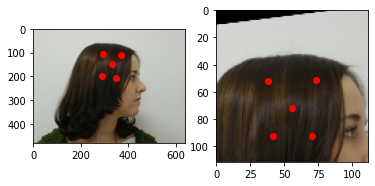

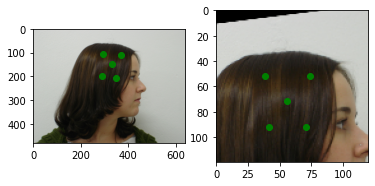

In [ ]:
print('Confidence: {}'.format(idx_confidence[1][0]))
show_aligned_and_marked(idx_data[1][0],idx_data[1][1])

## Loading PreTrained Model (RetinaFace)


In [ ]:
fd_sym, fd_param, fd_auxp = mx.model.load_checkpoint('fd',0000)
